# Check the sentence profanity classification



|  hate speech  | offensive language  |  neither |  
|---|---|---| 
| 0  |  1 |  2 |  

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import re
import os
import math
import pprint as pp


# Data 

## Download data

In [ ]:
URL = "https://dl.dropbox.com/s/ewpit86gekpiwk5/hate_dirty_peech_labeled_data.tsv"
path = tf.keras.utils.get_file(URL.split('/')[-1], URL)
data = pd.read_csv(path, sep="\t")


## Shuffle data

In [ ]:
data = data.sample(frac=1)
data.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
24499,25013,3,0,2,1,1,the bae gettin her nips pierced &#128525;&#128...
14382,14732,3,0,3,0,1,RT @BiggMoe_: Floyd Mayweather stay with a bad...
15594,15967,3,0,2,1,1,RT @If_ItAint_B: Miami isn't a good city at al...
20593,21048,3,0,0,3,2,Saltine crackers for dinner lol. Sad lyfe.
18671,19092,3,1,2,0,1,RT @bonita_kayla: all bitches wanna do is beef...


## Clean data

In [ ]:
data = data[pd.notnull(data['class'])]
data = data[pd.notnull(data['tweet'])]
data = data.drop(data.columns[0], axis=1) 
data = data.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither']) 
 
data["tweet"] = data["tweet"].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 

data["label"] = data["class"]

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
data['class'].astype(str)
data = data.replace({'class': {0: "hate speech", 1: "offensive language", 2: "neither"}})

# Print the first first five rows as default
data.head(50)


,class,tweet,label
24499,offensive language,the bae gettin her nips pierced 128525128525,1
14382,offensive language,RT Floyd Mayweather stay with a badd bitch lol,1
15594,offensive language,RT ItAintB Miami isnt a good city at alldont b...,1
20593,neither,Saltine crackers for dinner lol Sad lyfe,2
18671,offensive language,RT kayla all bitches wanna do is beef over nig...,1
15251,offensive language,RT rt if u remember when steve from blue clue...,1
22236,offensive language,Too worried bout bitches amp fashion they go m...,1
2692,neither,we gunna laff at ChavaRubio beaner supporter...,2
20875,offensive language,Slide in the pussy like a surfboard,1
22165,neither,Thou shall not mock Ryanthe futureKelly,2


# Create texts and labels

## Create labels

In [ ]:
labels = data["label"].to_list()
print(labels[:10])


[1, 1, 1, 2, 1, 1, 1, 2, 1, 2]


In [ ]:
label_count = len(set(labels))
print(label_count)


3


### Create texts sequences

In [ ]:
texts = data["tweet"].to_numpy()
type(texts)
print(texts[:10])


['the bae gettin her nips pierced 128525128525'
 'RT  Floyd Mayweather stay with a badd bitch lol'
 'RT ItAintB Miami isnt a good city at alldont believe the shit you see on TV that city is trash'
 'Saltine crackers for dinner lol Sad lyfe'
 'RT kayla all bitches wanna do is beef over niggas 58382 grow tf up a get ya priorities straight 5793358167'
 'RT  rt if u remember when steve from blue clues left us with that other bitch ass nigga joe '
 'Too worried bout bitches amp fashion they go missing in action'
 '  we gunna laff at ChavaRubio beaner supporters in a min'
 'Slide in the pussy like a surfboard'
 'Thou shall not mock Ryanthe futureKelly']


In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)


In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index) + 1
print(total_words) 


27426


In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
total_sequences = len(sequences)
print(total_sequences)
print(sequences[:10])


24776
[[5, 452, 527, 52, 1017, 2829, 2210], [3, 3094, 3446, 291, 26, 1, 5673, 2, 57], [3, 7281, 2211, 432, 1, 90, 630, 54, 10654, 456, 5, 44, 6, 100, 17, 945, 10, 630, 13, 53], [4634, 528, 21, 1228, 57, 616, 5674], [3, 10655, 31, 12, 130, 64, 13, 1229, 124, 67, 7282, 769, 361, 30, 1, 35, 97, 4635, 346, 10656], [3, 3, 32, 43, 388, 39, 1805, 83, 770, 3932, 433, 235, 26, 10, 177, 2, 28, 46, 780], [92, 737, 134, 12, 63, 1925, 38, 79, 1633, 11, 1722], [68, 1723, 3933, 54, 10657, 1305, 2568, 11, 1, 2371], [1230, 11, 5, 22, 14, 1, 7283], [2212, 2569, 47, 476, 10658, 10659]]


In [ ]:
max_len = max([len(s) for s in sequences])
print(max_len)


57


### Shift each sequence to generate more "texts"

In [ ]:
def shift_sequences(unshifted_sequences, labels):
  shifted = []
  i = -1
  for seq in unshifted_sequences:
    i = i + 1
    length = len(seq)
    shifted.append((seq, labels[i]))
    if length > 3: [shifted.append((seq[:-shift], labels[i])) for shift in range(1, length-1)]  
  return shifted


In [ ]:
shifted_sequences_labels = np.array(shift_sequences(sequences, labels))

sequences = shifted_sequences_labels[:,:-1][:,0]
print(sequences[:3])

labels = shifted_sequences_labels[:,-1]
print(labels[:3])

total_sequences = len(sequences)
print(total_sequences)

[list([5, 452, 527, 52, 1017, 2829, 2210])
 list([5, 452, 527, 52, 1017, 2829]) list([5, 452, 527, 52, 1017])]
[1 1 1]
304862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    padding = "post",
    maxlen = max_len
)

#padded_sequences = tf.expand_dims(padded_sequences, axis=-1)
print(type(padded_sequences))
print(padded_sequences[:5])

labels = np.asarray(labels).astype(np.int)
print(labels[:5])

<class 'numpy.ndarray'>
[[   5  452  527   52 1017 2829 2210    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52 1017 2829    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52 1017    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52    0    0    0    0    0    0    0    0    0    0
     0    0    0

## Divide training data and testing data

### Training data

In [ ]:
boundary = int(.85 * total_sequences)

training_sequences = padded_sequences[:boundary]
training_labels = labels[:boundary]

print(len(training_sequences))
print(len(training_labels))

print(training_sequences[:5])
print(training_labels[:5])


259132
259132
[[   5  452  527   52 1017 2829 2210    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52 1017 2829    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52 1017    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   5  452  527   52    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0

### Testing data

In [ ]:
testing_sequences = padded_sequences[boundary:]
testing_labels = labels[boundary:]

total_testing_sequences = len(testing_sequences)
print(total_testing_sequences)
print(len(testing_labels))

print(testing_sequences[:5])
print(testing_labels[:5])


45730
45730
[[  23 2331  502    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  23 2331    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  83   86   17    4  108  142   31 7039 2515  423   24   13  741 5089
     8   24   13  525    4  191  525  673  635   76 1712  688    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  83   86   17    4  108  142   31 7039 2515  423   24   13  741 5089
     8   24   13  525    4  

# Machine-learning

## Hyperparameters

In [ ]:
epochs = 1#100
embedding_dim = 215


## Utils, like output, graphic etc....

### Table of *prediction*

In [ ]:
import matplotlib.pyplot as plt

def predict_output(texts, predicated_classes):
    fig, ax = plt.subplots()
    ax.axis('off')

    predicated_classes = np.expand_dims(predicated_classes, axis=-1)

    table = ax.table(
             rowLabels=texts,  
             colLabels=["classification"],  
             cellText=predicated_classes, 
             cellLoc="center", 
             loc="center"
    )
    table.scale(0.5, 1)  
    
    ax.set_title('0: "hate speech", 1: "offensive language", 2: "neither"',
              fontweight ="bold")

    fig.tight_layout()
    plt.show()

### 📊Grpahic of training

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

def plot(history, m0, m1): 
  h_m0=history.history[m0] 
  h_m1=history.history[m1] 
  epochs=range(len(h_m0))  
  plt.plot(epochs, h_m0, 'b', m0) 
  plt.figure()  
  plt.plot(epochs, h_m1, 'b', m1)  

## Methods

### 🎉Method of building model

In [ ]:
def build_model(*layers):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Embedding(
            input_dim=total_words,
            output_dim=embedding_dim,
            input_length=max_len
        ),
    ) 
    [model.add(layer) for layer in layers]

    model.add(tf.keras.layers.Dropout(.5))
    model.add(tf.keras.layers.Dense(total_words / 2,
                                    activation=tf.keras.activations.relu, 
                                    bias_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(tf.keras.layers.Dense(label_count, activation=tf.keras.activations.softmax))
 
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    model.summary()

    return model

In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2)

### 🏋️‍♀️Method of traning 

In [ ]:
def train_model(model):
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    return model.fit(
              x=training_sequences, 
              y=training_labels, 
              #validation_split
              #validation_data=(valid_sequences, valid_labels)
              #wont make sense see: https://stackoverflow.com/a/57391324/1835650
              verbose=1,
              epochs=epochs,
              callbacks=[earlyStop])

### Method of prediction

In [ ]:
def predict(model, texts):
    tokenizer.fit_on_texts(texts)
    tokenized_texts = tokenizer.texts_to_sequences(texts)
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_texts,
        maxlen = max_len,
        padding = "post", 
    )
    predicted = model.predict(padded_texts)
    predicted_classes = np.argmax(predicted, axis=-1)

    print("texts: {}".format(texts))
    print("tokenized_texts: {}".format(tokenized_texts))
    print("padded_texts: {}".format(padded_texts))
    print("predicted: {}".format(predicted))
    print("predicted class: {}".format(predicted_classes))
    predict_output(texts, predicted_classes)

### Method of evaluation

In [ ]:
def evaluate_model(model):
  print("Evaluate on test data")
  results = model.evaluate(testing_sequences, testing_labels) 

## Try model without training

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 57, 215)           5896590   
_________________________________________________________________
global_average_pooling1d (Gl (None, 215)               0         
_________________________________________________________________
dropout (Dropout)            (None, 215)               0         
_________________________________________________________________
dense (Dense)                (None, 13713)             2962008   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 41142     
Total params: 8,899,740
Trainable params: 8,899,740
Non-trainable params: 0
_________________________________________________________________
texts: ['hello', 'bad man', 'fuck you', 'suck you', 'you bitch']
tokenized_texts: [[1611], [84, 91], [36, 6], [3

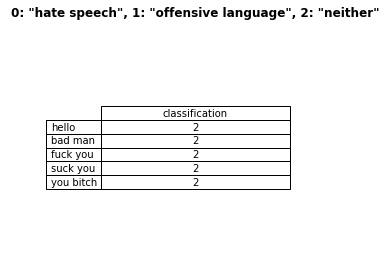

In [ ]:
model = build_model(tf.keras.layers.GlobalAveragePooling1D())
predict(model, ["hello", "bad man", "fuck you", "suck you", "you bitch"])

## 💥Training

In [ ]:
model = build_model( 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
)
history = train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 57, 215)           5896590   
_________________________________________________________________
bidirectional (Bidirectional (None, 57, 64)            63488     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 57, 32)            10368     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 57, 16)            2624      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13713)            

## Training completed

### Result

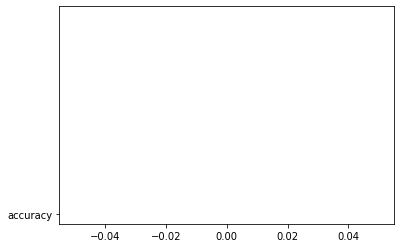

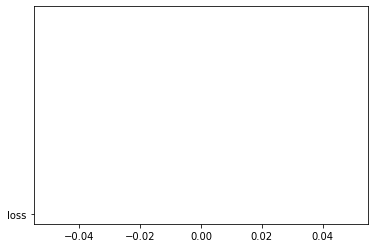

In [ ]:
plot(history, "accuracy", "loss")


### Try to predict

texts: ['good people']
tokenized_texts: [[90, 111]]
padded_texts: [[ 90 111   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]
predicted: [[0.07663379 0.6794242  0.24394202]]
predicted class: [1]


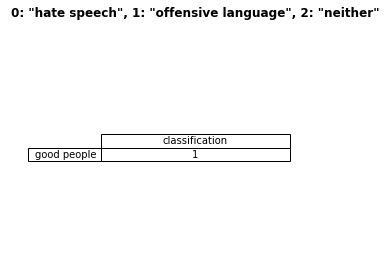

In [ ]:
predict(model, ["good people"])


### Evaluation

In [ ]:
evaluate_model(model)

Evaluate on test data
1430/1430 [==============================] - 14s 9ms/step - loss: 0.9692 - accuracy: 0.8022
